### ONE Phyrexia Analysis ###

<h3>Imports</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split


<h3>Data Transformation</h3>

Open up our data, from our raw data, we will select just the draft_id, pick, games_won, and pick_maindeck_rate, which we will preprocess into rows that look like [card in deck] [games won]. A deck will be able to have half cards since players may have changed deck composition mid way through the game.

In [2]:
df = pd.read_csv("ONE_premier_draft_data.csv", usecols = ['draft_id','event_match_wins', 'pick','pick_maindeck_rate'], nrows=45*5000)

In [3]:
#Start our decks dataframe by finding all the unique drafts along with how many games they won
agg_functions = {'event_match_wins' : 'first'}
decks = df[['draft_id', 'event_match_wins']].groupby('draft_id').aggregate(agg_functions)

#Add one column to decks for each card in the set and initialize the values to 0
cards = df['pick'].unique()
new_cols = []
for card in cards:
    new_cols.append(card)
decks = decks.reindex(columns=decks.columns.tolist() + new_cols)   # add empty cols
decks[cards] = 0

#For each pick, we add the average number of copies that made the main deck
#Main deck rate is in [0,1] so if a card got picked twice and both copies 
#we in the main deck, we would have two rows that look like DRAFT, CARDNAME, 1
#so the resulting value of decks[DRAFT, CARDNAME] would be 2
for _, row in df[['draft_id', 'pick', 'pick_maindeck_rate']].iterrows():
    decks.loc[row['draft_id'],row['pick']] += row['pick_maindeck_rate']



#Only consider rows with a sum greater than 18
#Any deck with fewer cards is an outlier
#Note this is kinda hacky as we're still summing with the event_match_wins 
decks = decks.loc[(decks.sum(axis=1) > 18)]
decks['event_match_wins'] = decks['event_match_wins'].apply(lambda x: int(x >= 5))
decks = decks.round(0)

X_train, X_test, y_train, y_test = train_test_split(decks.loc[:, decks.columns != 'event_match_wins'], decks['event_match_wins'], test_size=0.2, random_state=42)


<h3>kNN-Model</h3>

Train: 1.0, Test: 0.6197183098591549
Train: 0.8148148148148148, Test: 0.6549295774647887
Train: 0.7583774250440917, Test: 0.6408450704225352
Train: 0.7495590828924162, Test: 0.7183098591549296
Train: 0.7336860670194003, Test: 0.6549295774647887
Train: 0.708994708994709, Test: 0.6549295774647887
Train: 0.7037037037037037, Test: 0.6830985915492958
Train: 0.6984126984126984, Test: 0.676056338028169
Train: 0.6984126984126984, Test: 0.6901408450704225
Train: 0.6948853615520282, Test: 0.7112676056338029
Train: 0.689594356261023, Test: 0.6971830985915493
Train: 0.6878306878306878, Test: 0.6971830985915493
Train: 0.6931216931216931, Test: 0.7183098591549296
Train: 0.689594356261023, Test: 0.7183098591549296
Train: 0.6878306878306878, Test: 0.704225352112676
Train: 0.689594356261023, Test: 0.6971830985915493
Train: 0.689594356261023, Test: 0.6971830985915493
Train: 0.6878306878306878, Test: 0.7112676056338029
Train: 0.691358024691358, Test: 0.7112676056338029
Train: 0.6825396825396826, Test: 0.

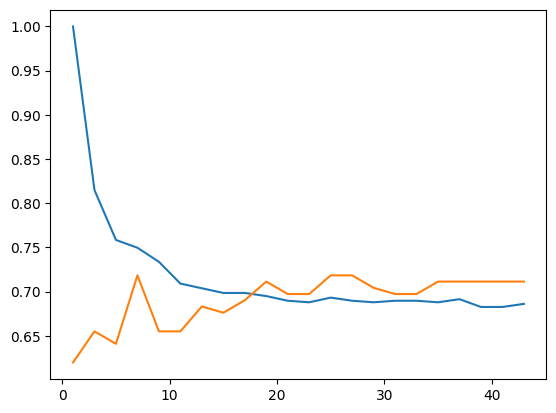

In [13]:
num_neighbors = range(1,45,2)
train_accuracies = []
test_accuracies = []
neigh = KNeighborsClassifier(n_neighbors=1)
for n in num_neighbors:
    neigh.n_neighbors = n
    neigh.fit(X_train, y_train)
    train_accuracy = neigh.score(X_train,y_train)
    train_accuracies.append(train_accuracy)
    test_accuracy = neigh.score(X_test,y_test)
    test_accuracies.append(test_accuracy)
    print(f"Train: {train_accuracy}, Test: {test_accuracy}")

plt.plot(num_neighbors, train_accuracies)
plt.plot(num_neighbors, test_accuracies)
plt.show()


This is the baseline we have to beat. If we can't get above this percentage we might as well just be guessing

In [38]:
total_winning_decks = decks["event_match_wins"].sum()
total_decks = decks["event_match_wins"].count()
print(total_winning_decks/total_decks)
print(1- total_winning_decks/total_decks)

0.3127587504704554
0.6872412495295446


<h3>Naive Bayes</h3>

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

gnb = GaussianNB()
scaler = StandardScaler()
gaussian_X_train = scaler.fit_transform(X_train)
gnb.fit(gaussian_X_train, y_train)
gaussian_X_test = scaler.transform(X_test)
accuracy = gnb.score(gaussian_X_test, y_test)
print(f"Gaussian Naive Bayes Accuracy: {accuracy}")

Gaussian Naive Bayes Accuracy: 0.323943661971831


<h3>Random Forest</h3>

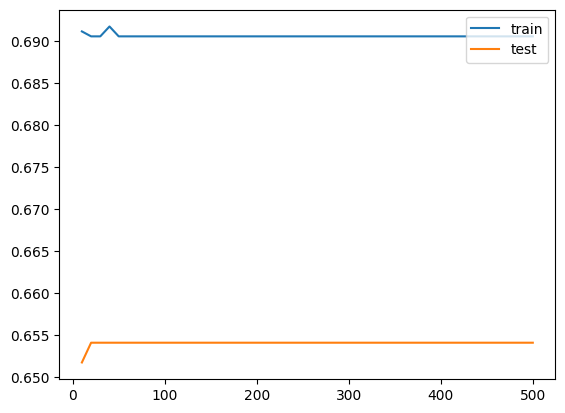

In [35]:
from sklearn.ensemble import RandomForestClassifier

num_trees = range(10, 501, 10)
train_accuracies = []
test_accuracies = []
for n in num_trees:
    random_forest = RandomForestClassifier(n_estimators=n, max_depth=4)
    random_forest.fit(X_train, y_train)
    train_accuracy = random_forest.score(X_train,y_train)
    train_accuracies.append(train_accuracy)
    test_accuracy = random_forest.score(X_test,y_test)
    test_accuracies.append(test_accuracy)

plt.plot(num_trees, train_accuracies, label="train")
plt.plot(num_trees, test_accuracies, label="test")
plt.legend(loc="upper right")
plt.show()

<h3>PyTorch / Neural Net</h3>

In [22]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import torch
from torch import nn, Tensor
from torch.utils.data import TensorDataset, DataLoader
import DraftNeuralNet

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

model = DraftNeuralNet.NeuralNet(len(cards)).to(device)
print(model)


# Create data loaders.
batch_size = 64
train_tensor = TensorDataset(Tensor(X_train.values), Tensor(y_train.values))
test_tensor = TensorDataset(Tensor(X_test.values), Tensor(y_test.values))
train_tensor = train_tensor.type(torch.LongTensor)
test_tensor = test_tensor.type(torch.LongTensor)
train_dataloader = DataLoader(train_tensor, batch_size=batch_size)
test_dataloader = DataLoader(test_tensor, batch_size=batch_size)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    DraftNeuralNet.train(train_dataloader, model, loss_fn, optimizer, device)
    DraftNeuralNet.test(test_dataloader, model, loss_fn, device)
print("Done!")



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
NeuralNet(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=265, out_features=530, bias=True)
    (1): ReLU()
    (2): Linear(in_features=530, out_features=530, bias=True)
    (3): ReLU()
    (4): Linear(in_features=530, out_features=2, bias=True)
  )
)


AttributeError: 'TensorDataset' object has no attribute 'type'